In [270]:
import numpy as np
import numba as nb
from scipy.stats import maxwell
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from copy import copy
from matplotlib.widgets import Slider
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Periodic boundary conditions
# Rabbits are field with positions, velocities, awareness radius.
NVAR = 5
PVAR = NVAR-1
N = 50
R = 0.15
GA = 0.2
RA = 10
PA = 1/30
dt = 0.01
ms = 5
PRED_NOISE = 0.02
RADIUS_PRED = 0.2
Niterations = 100
MAX_SPEED = 0.01/dt
PRED_SPEED = MAX_SPEED #NEW
DECAY_RATE = 0.995

In [271]:
def init_rabbits(N, NVAR):
    # Velocities and positions
    rabbits = np.zeros((N, NVAR))

    positions = np.random.rand(N, 2)
    rabbits[:, 0:2] = positions
    
    velocities = 0#T * (np.random.rand(N, 2) - 1/2)
    rabbits[:, 2:4] = velocities
    
    return rabbits

def init_nn_array(N):
    return np.zeros((N, N - 1))

def get_rn_noise(amplitude,rabbits):
    
    # Random walk
    N = len(rabbits)
    perturbation = amplitude * (np.random.rand(N, 2) - 0.5)
    return perturbation

In [272]:
from scipy.spatial import distance

def closest_node(node, nodes):
    """https://codereview.stackexchange.com/questions/28207/finding-the-closest-point-to-a-list-of-points"""
    return distance.cdist([node[:2]], nodes[:,:2]-node[:2]).argmin()

def get_closest_other(rabbits,predators):
    """Get closest rabbit-predator pair"""
    return np.apply_along_axis(closest_node, 1, rabbits, predators)

In [311]:
def init_predators(N,PVAR):
    # Velocities and positions
    predators = np.zeros((N, PVAR))

    positions = np.random.rand(N, 2)
    predators[:, 0:2] = positions
    
    velocities = np.random.rand(N, 2)-1/2
    predators[:, 2:4] = velocities
    return predators

In [312]:
def predator_force(zero, distances, RADIUS_PRED, PA):
    mask = np.linalg.norm(distances-zero[:4]) > RADIUS_PRED
    distances[mask] = np.inf
    return PA/distances

def get_predators_force(rabbits, predators, PA):
    return np.apply_along_axis(predator_force, 1, rabbits, predators.copy(), RADIUS_PRED,PA).sum(axis=1)[:,2:4]

In [313]:
def update_velocities(rabbits, predators, dt,nn_array,combination_array,nn_indices):
    # Rabbits
    nn_array,combination_array,nn_indices = get_nn(rabbits, R,nn_array,combination_array,nn_indices)
    group_force = get_group_influence(GA, nn_array, rabbits)
    perturbation = get_rn_noise(RA,rabbits)
    predators_force = get_predators_force(rabbits, predators, PA)
    rabbits[:, 2:4] += dt * (group_force + perturbation + predators_force) 
    rabbits[:, 2:4] *= DECAY_RATE

    for rabbit in rabbits:
        v = np.linalg.norm(rabbit[2:4])
        if v > MAX_SPEED:
            rabbit[2:4] = rabbit[2:4] * MAX_SPEED/ v
    
    # Predator
    closest_rabbits = get_closest_other(predators,rabbits) #IDK how to normalize properly
    predators[:, 2:4] = PRED_SPEED*((rabbits[closest_rabbits][:,:2]-predators[:, :2])/
                                    np.linalg.norm((rabbits[closest_rabbits][:,:2]-predators[:, :2]),axis=1)[:,None]**2)
    predators[:, 2:4] += PRED_NOISE * (np.random.rand(2) - 0.5)
    return rabbits, predators, nn_array,combination_array,nn_indices

def step(rabbits, predators, dt,nn_array,combination_array,nn_indices):
    rabbits, predators, nn_array, combination_array, nn_indices = update_velocities(rabbits, predators, 
                                                                                    dt,nn_array, combination_array,nn_indices)
    
    rabbits[:, 0] = (rabbits[:, 0] + dt * rabbits[:, 2]) % 1
    rabbits[:, 1] = (rabbits[:, 1] + dt * rabbits[:, 3]) % 1

    predators[:, 0] = (predators[:, 0] + dt * predators[:, 2]) % 1
    predators[:, 1] = (predators[:, 1] + dt * predators[:, 3]) % 1

    return rabbits, predators

def get_nn(rabbits, r,nn_array,combination_array,nn_indices):
    """
    Returns array nn_indices, where the N-th elements contains the indices of the N-th rabbit
    
    shape nn_indices = N
    """
    
    # Clean arrays
    nn_array[:, :] = -1
    combination_array[:, :] = 0
    nn_indices[:] = 0
    
    # For loop has O(N^@)
    for i, rabbit in enumerate(rabbits):
        for j, rabbit_n in enumerate(rabbits):
            # Remove self-interaction
            if i != j:
                # Remove redundant calculations
                if combination_array[i, j] != 1:
                    combination_array[i, j] = 1
                    combination_array[j , i] = 1
                    # Possible new swarm interaction
                    d = np.linalg.norm(rabbit[0:2] - rabbit_n[0:2])
                    if d < r:
                        nn_array[i, nn_indices[i], 0] = j
                        nn_array[j, nn_indices[j], 0] = i
                        nn_array[i, nn_indices[i], 1] = d
                        nn_array[j, nn_indices[j], 1] = d
                        nn_indices[i] += 1
                        nn_indices[j] += 1
                        
    return nn_array,combination_array,nn_indices

#@nb.njit
def get_group_influence(amplitude, nn,rabbits ):
    """Given the nearest neighbor array, calculates the swarm influence 

    Parameters
    ----------
    rabits : float array
        Array containing all values of positions and velocities of the rabbits.
    nn_array : int, float array
        Array where N-th elements contains the indices combined with distances to nearest neighbors.

    Returns
    -------
    float array
        N, 2 float array which describes the force caused by the group
    """
    
    # TODO Add weighted sums (closer neighbors have more influence)
    #total_weights = np.zeros((N))
    
    
    group_velocities = np.zeros((N, 2))
    
    # Collect weights
    #for i, rabbit in enumerate(nn):
    #    total_weights[i] = np.sum(rabbit[:, 0])
    
    temp_vel = np.zeros((2))
    # Calculate the average velocity vector of neighbors weighed proportionally to their distance
    for i, rabbit in enumerate(nn):
        # No neighbors
        #if total_weights[i] == 0:
            #break
        
        temp_vel[:] = 0
        for neighbor in rabbit:
            if neighbor[0] == -1:
                break
            else:
                # Neighbor 0 is index
                # Neighbor 1 is distance
                temp_vel += rabbits[neighbor[0], 2:4]
        #temp_vel /= total_weights[i]
        # TODO MIGHT NEED TO ADD COPY AGAIN
        group_velocities[i] = temp_vel
        temp_vel[:] = 0
        
    return amplitude * group_velocities          

In [314]:
def run(N, N_P, NVAR, PVAR, Niterations):
    rabbits = init_rabbits(N, NVAR)
    predators = init_predators(N_P, PVAR)
    nn_array = np.zeros((N, N, 2), dtype = np.int)
    combination_array = np.zeros((N, N), dtype = np.int)
    nn_indices = np.zeros((N), dtype = np.int)
    
    data_rabbits = np.zeros((Niterations, N, NVAR))
    data_predators = np.zeros((Niterations, N_P, PVAR))
    
    data_rabbits[0,:,:] = rabbits.copy()
    data_predators[0,:,:] = predators.copy()
    
    for i in range(1,Niterations):
        rabbits, predators = step(rabbits, predators, dt,nn_array,combination_array,nn_indices)
        data_rabbits[i,:,:] = rabbits.copy()
        data_predators[i,:,:] = predators.copy()
        if data_rabbits[i-1,0,0] == rabbits[0,0]:
            print("Kutzooi")
    return data_rabbits, data_predators

In [315]:
from tqdm import tqdm
def runs(N, N_P, NVAR, PVAR, Niterations, runs):
    data_rabbits = np.zeros((runs,Niterations,N, NVAR))
    data_predators = np.zeros((runs,Niterations,N_P, PVAR))
    
    for i in tqdm(range(runs)):
        rabbits, predators = run(N, N_P, NVAR, PVAR, Niterations)
        data_rabbits[i, :, :, :] = rabbits.copy()
        data_predators[i, :, :, :] = predators.copy()
    np.save("runs/{}_{}_{}_{}_rabbits.npy".format(N, N_P, Niterations, runs), data_rabbits)
    np.save("runs/{}_{}_{}_{}_pred.npy".format(N, N_P, Niterations, runs), data_predators)
    return data_rabbits, data_predators

In [316]:
# for i in range(1,N):
#     np.random.seed(i)
#     runs(N, i, NVAR, PVAR, Niterations, 50)

In [317]:
stds = np.zeros(N-1)
means = np.zeros(N-1)
for i in range(1,N):
    rab = np.load("runs/{}_{}_{}_{}_rabbits.npy".format(N, 1, Niterations, 50))
    stds[i-1] = np.std(rab[:,-1,:],ddof=1)
    means[i-1] = np.mean(rab[:,-1,:])

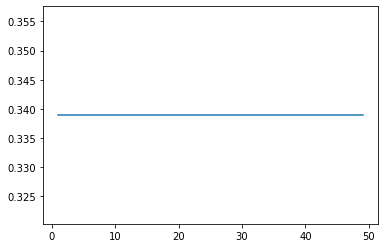

In [318]:
plt.plot(np.arange(1,N),stds)

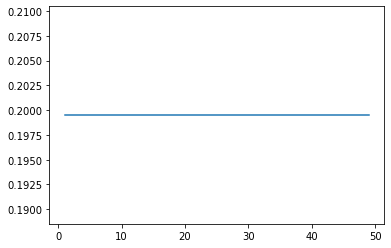

In [319]:
plt.plot(np.arange(1,N),means)

In [324]:
data_rab, data_pred = runs(N, 50, NVAR, PVAR, Niterations, 50)

100%|██████████| 50/50 [00:49<00:00,  1.02it/s]


<ipython-input-329-005fd8853102>:13: RuntimeWarning: divide by zero encountered in log
  im = ax.imshow(np.log(data),cmap="hot", origin="Bottom", interpolation='none',extent=[bins[0],bins[-1],0,Niterations],aspect="auto")


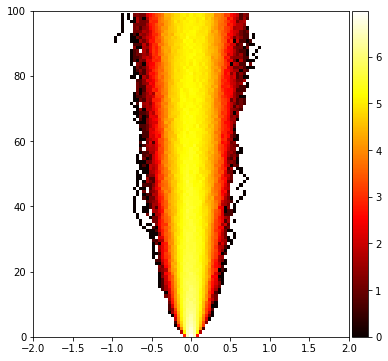

In [329]:
# Niterations=250
rab = np.load("runs/{}_{}_{}_{}_rabbits.npy".format(N, 1, Niterations, 50))
pred = np.load("runs/{}_{}_{}_{}_pred.npy".format(N, 1, Niterations, 50))

binning = 101
bins = np.linspace(-2,2,binning+1)
data = np.zeros((Niterations, binning))
for i in range(Niterations-1):
    counts, _ = np.histogram(rab_V[:,i,:],bins=bins)
    data[i,:] = counts
    
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(np.log(data),cmap="hot", origin="Bottom", interpolation='none',extent=[bins[0],bins[-1],0,Niterations],aspect="auto")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

In [330]:
%matplotlib inline

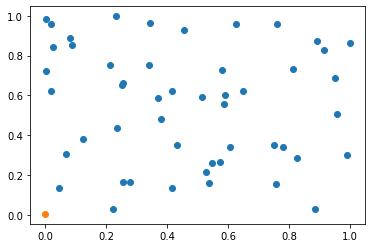

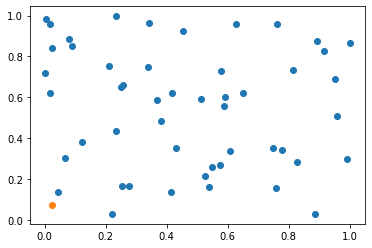

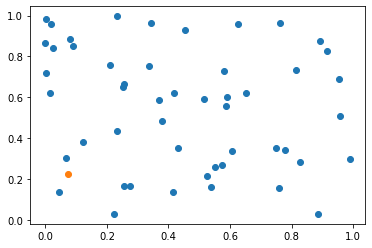

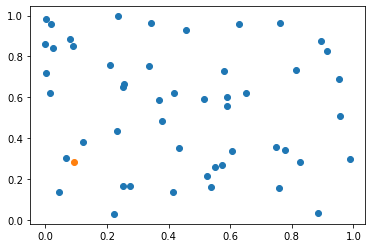

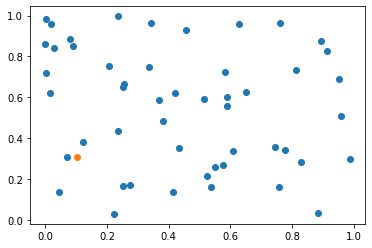

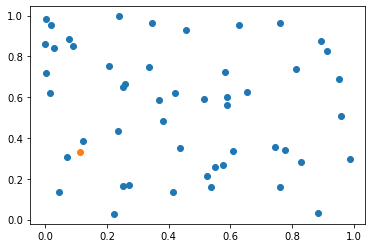

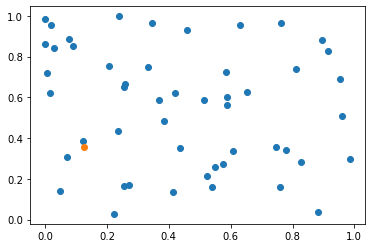

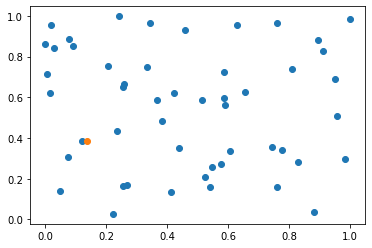

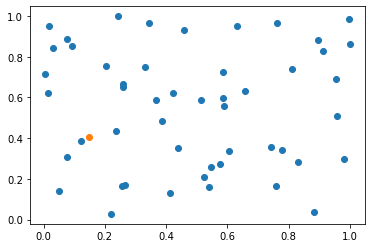

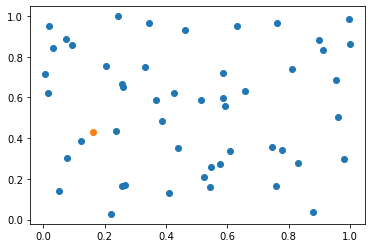

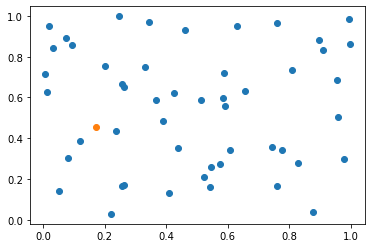

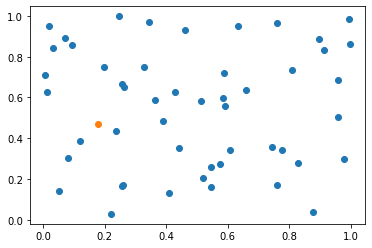

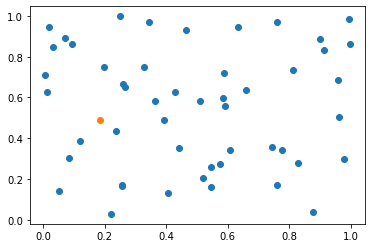

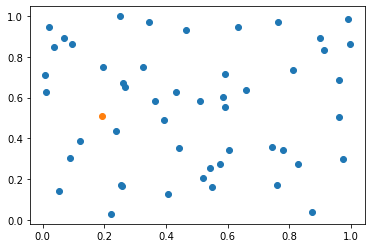

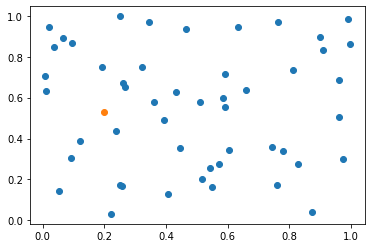

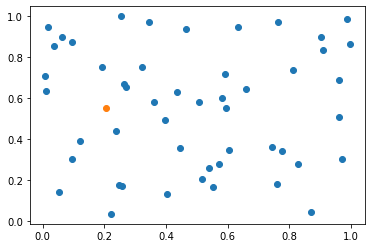

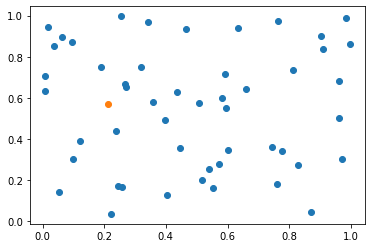

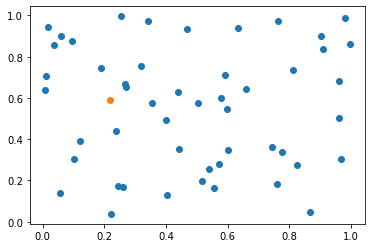

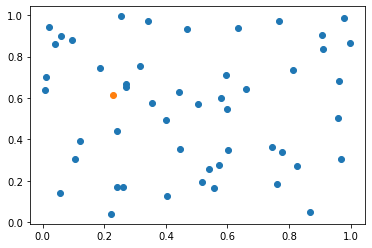

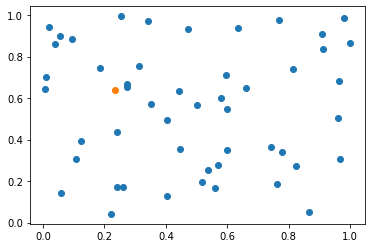

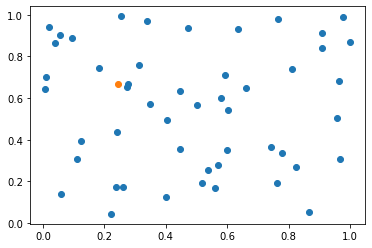

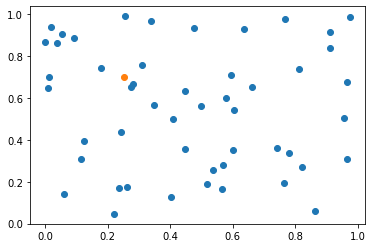

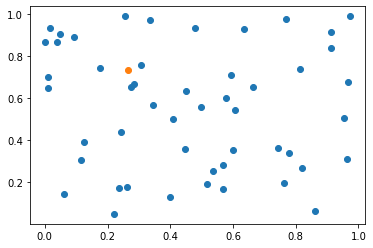

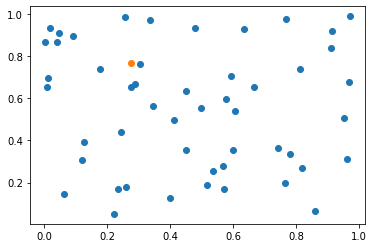

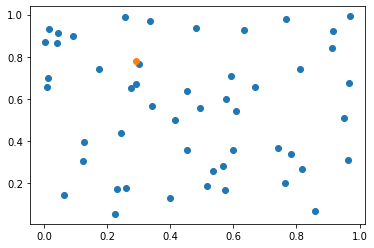

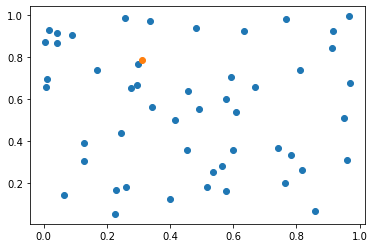

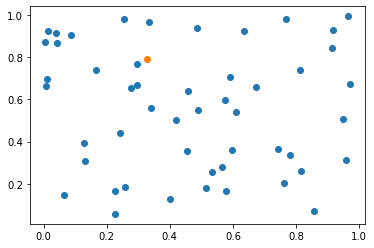

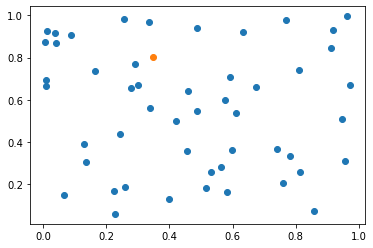

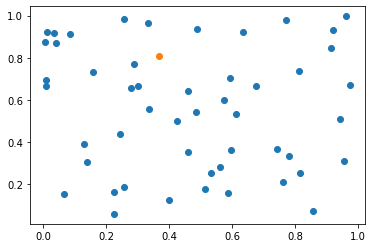

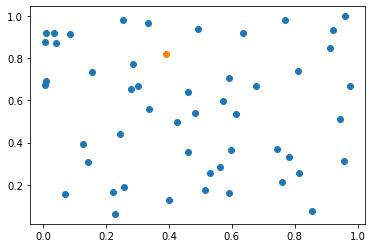

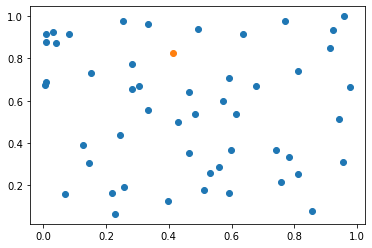

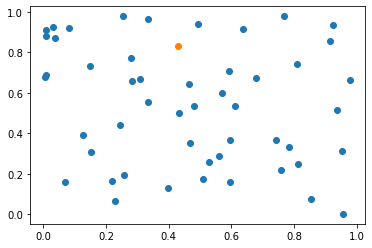

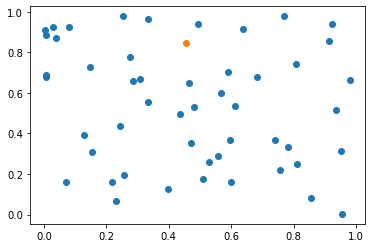

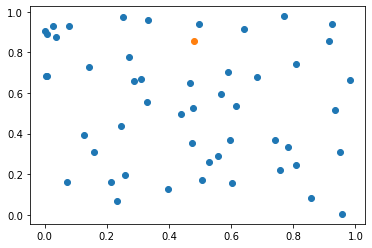

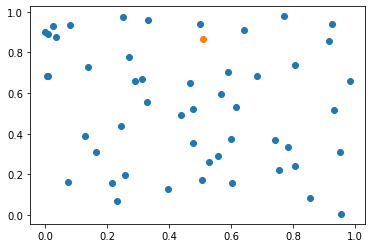

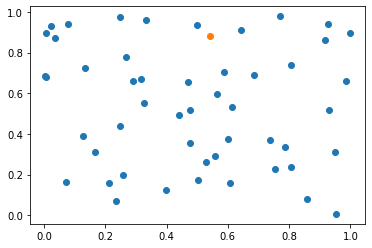

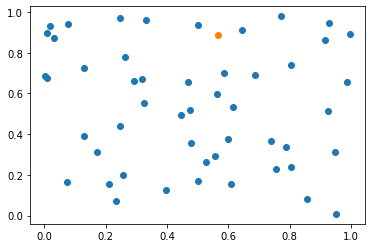

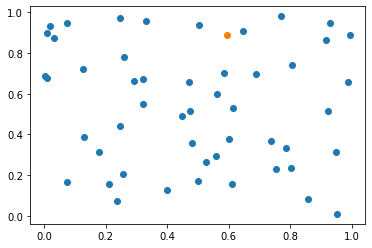

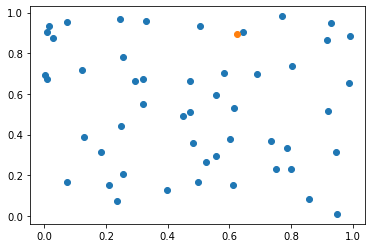

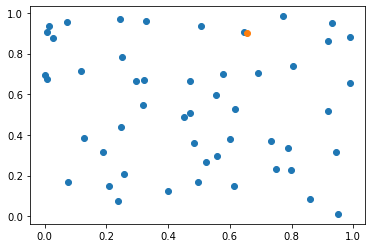

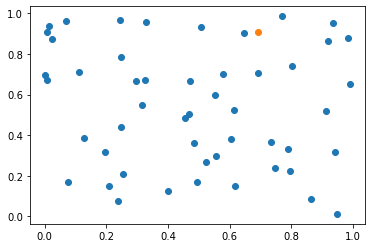

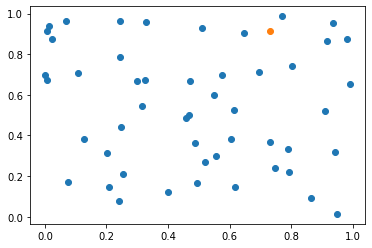

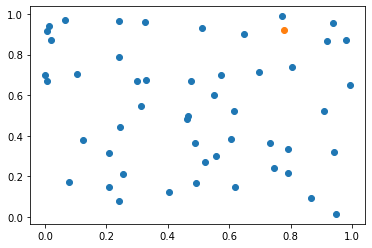

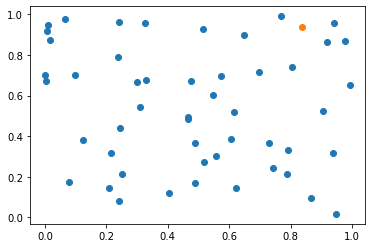

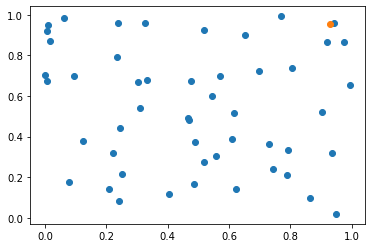

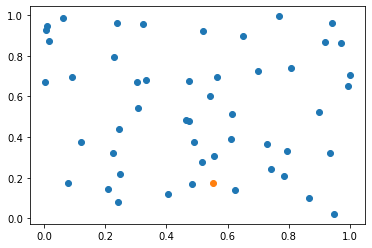

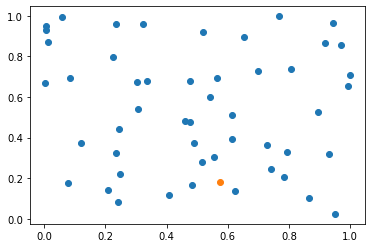

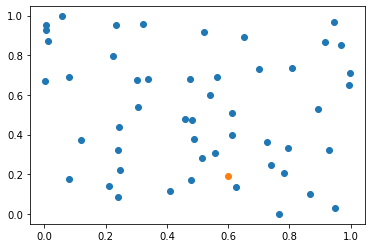

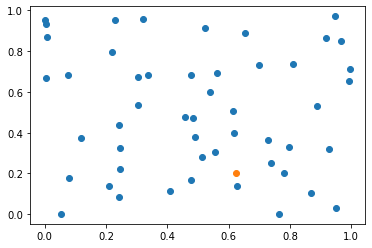

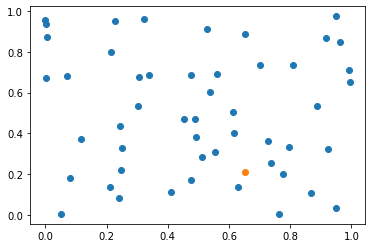

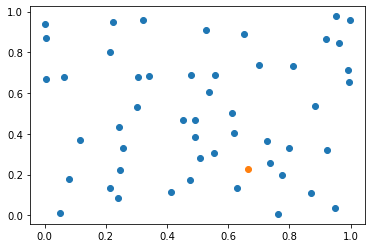

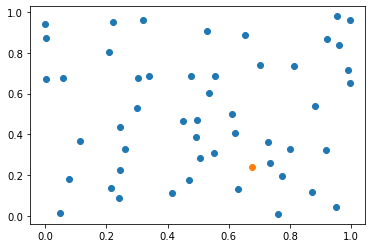

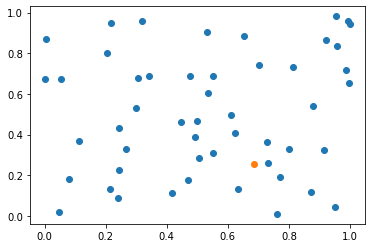

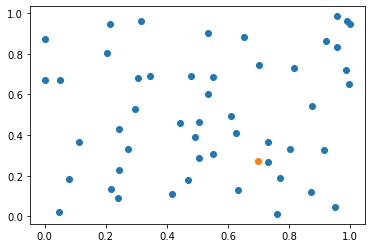

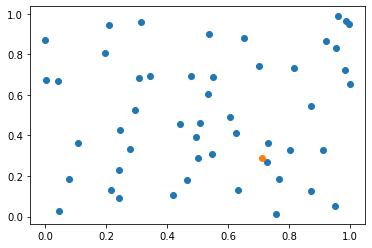

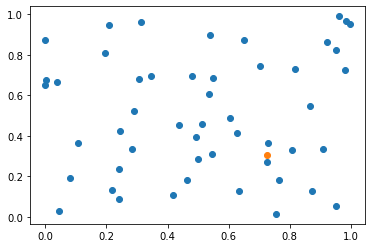

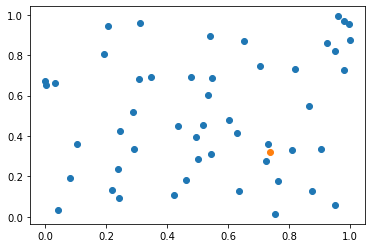

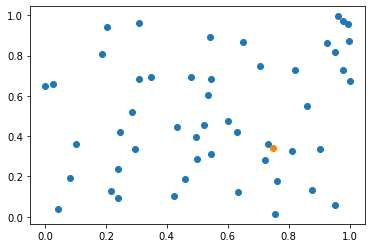

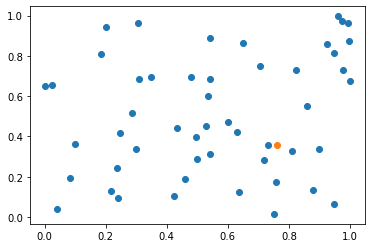

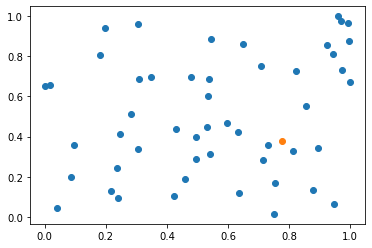

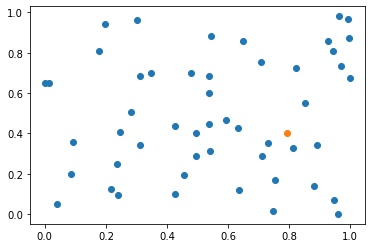

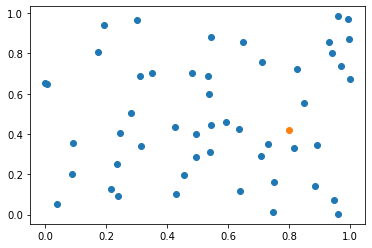

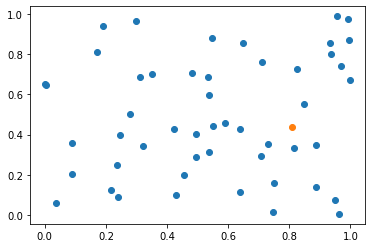

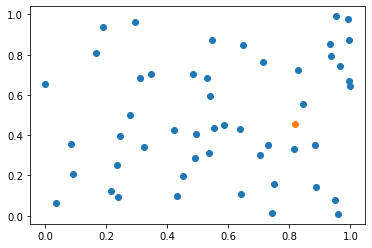

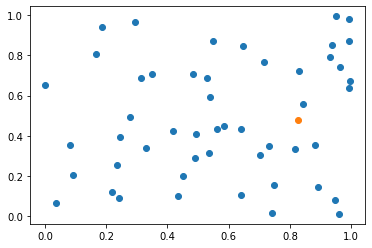

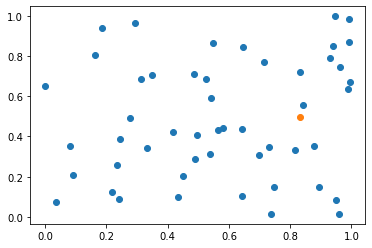

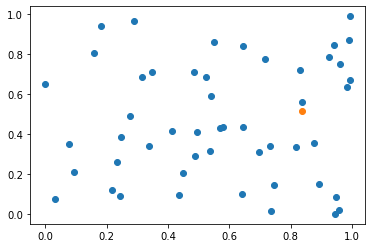

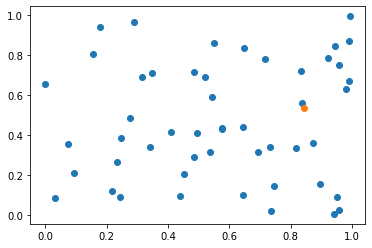

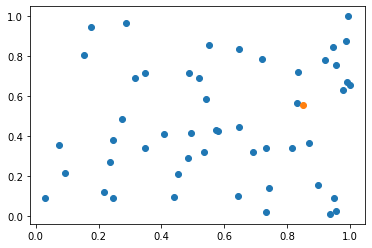

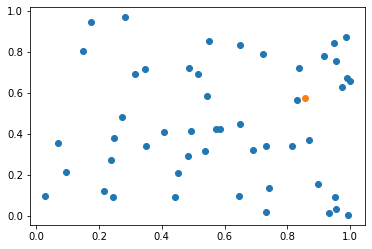

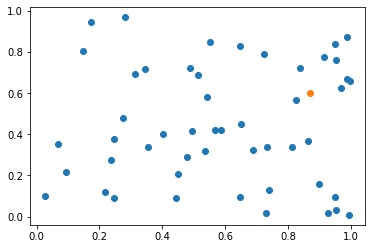

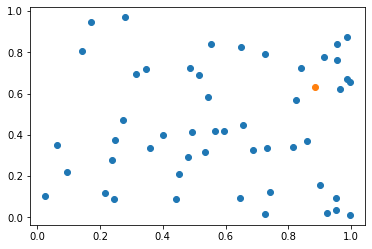

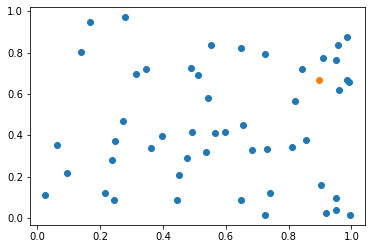

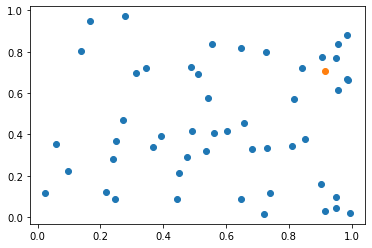

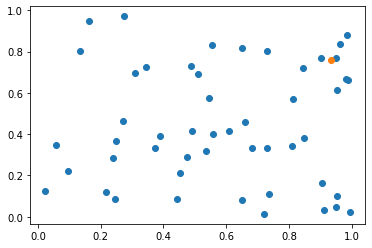

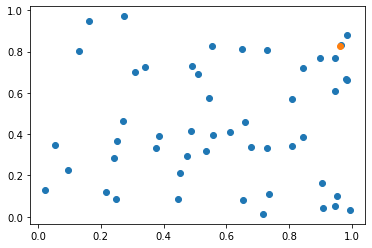

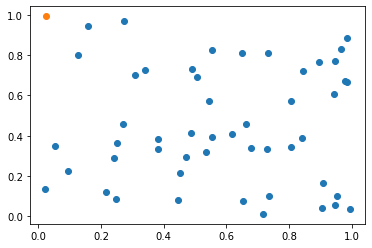

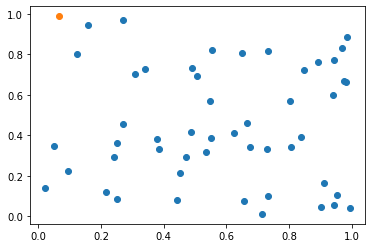

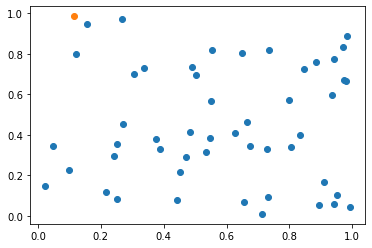

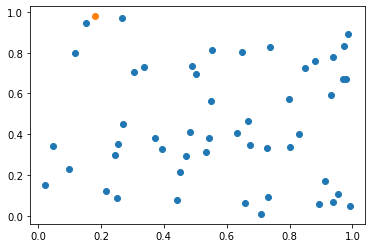

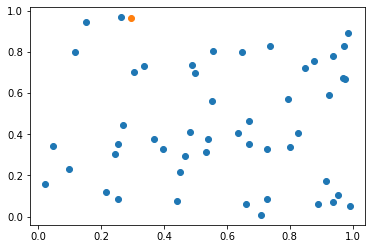

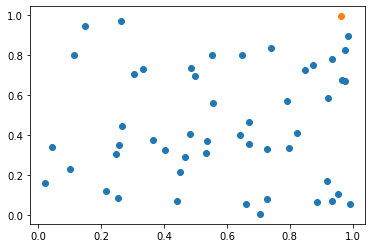

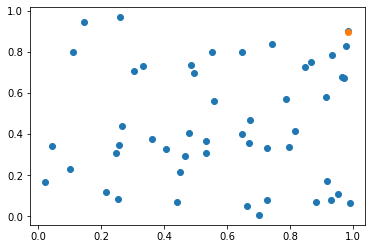

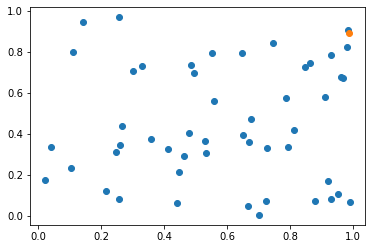

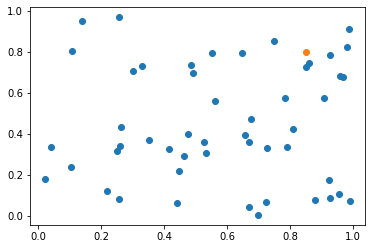

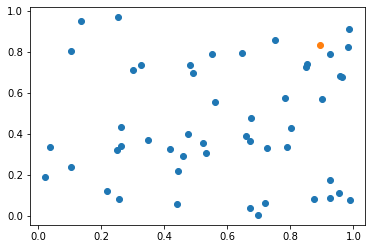

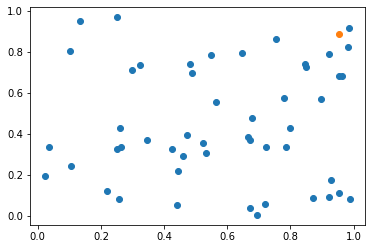

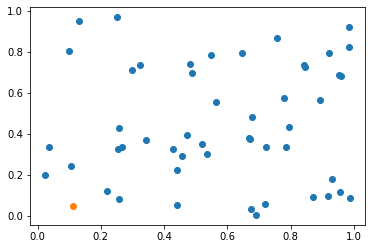

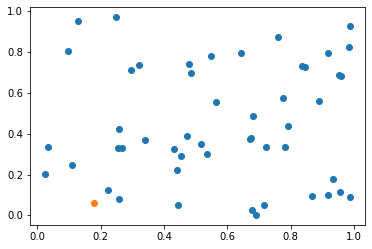

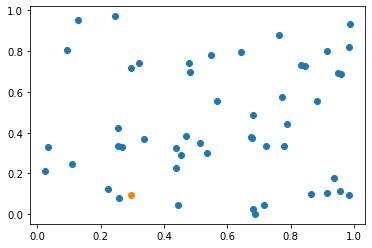

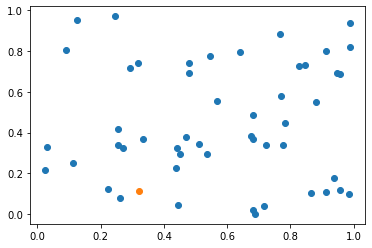

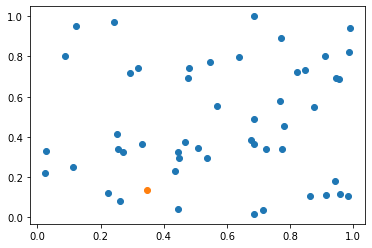

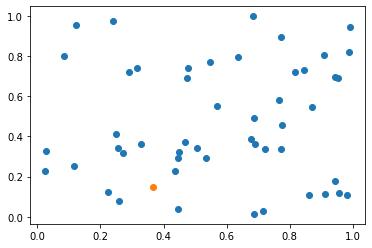

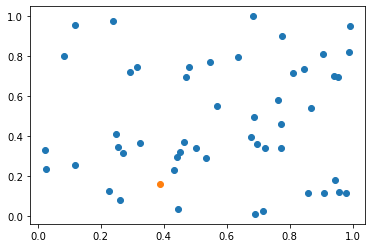

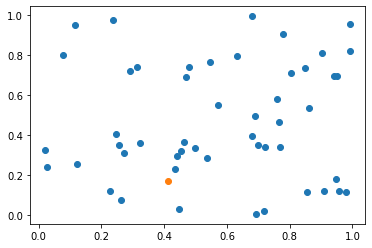

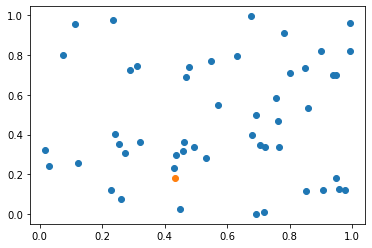

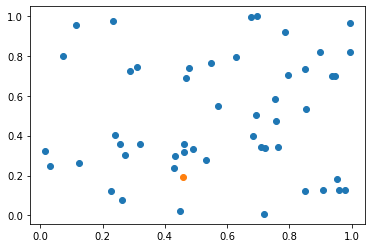

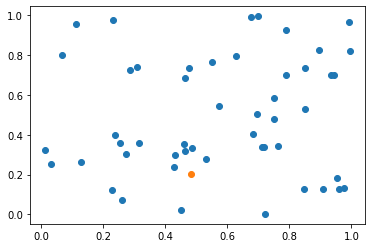

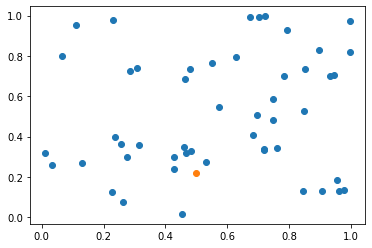

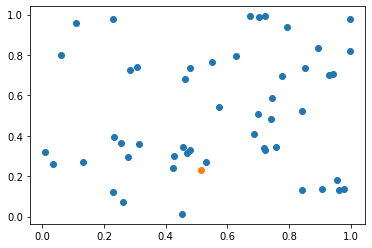

<Figure size 432x288 with 0 Axes>

In [331]:
for i in range(Niterations):
    plt.scatter(rab[0,i,:,0],rab[0,i,:,1])
    plt.scatter(pred[0,i,:,0],pred[0,i,:,1])
    plt.show()
    plt.pause(0.2)
    plt.clf()

<ipython-input-336-f171dd05e466>:16: RuntimeWarning: divide by zero encountered in log
  im = ax.imshow(np.log(data),cmap="hot", origin="Bottom", interpolation='none',extent=[bins[0],bins[-1],0,Niterations],aspect="auto")


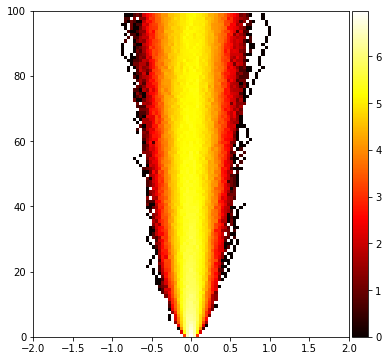

In [336]:
# Niterations=250
rab = np.load("runs/{}_{}_{}_{}_rabbits.npy".format(N, 49, Niterations, 50))
pred = np.load("runs/{}_{}_{}_{}_pred.npy".format(N,49, Niterations, 50))

rab_r = np.sqrt(rab[:,:,:,0]**2 + rab[:,:,:,1]**2)
rab_V = np.diff(rab_r,axis=1)/dt

binning = 101
bins = np.linspace(-2,2,binning+1)
data = np.zeros((Niterations, binning))
for i in range(Niterations-1):
    counts, _ = np.histogram(rab_V[:,i,:],bins=bins)
    data[i,:] = counts
    
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(np.log(data),cmap="hot", origin="Bottom", interpolation='none',extent=[bins[0],bins[-1],0,Niterations],aspect="auto")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

In [291]:
# rab = np.load("runs/{}_{}_{}_{}_rabbits.npy".format(N, 2, 1000, 50))
# pred = np.load("runs/{}_{}_{}_{}_pred.npy".format(N, 2, 1000, 50))
# Niterations=1000

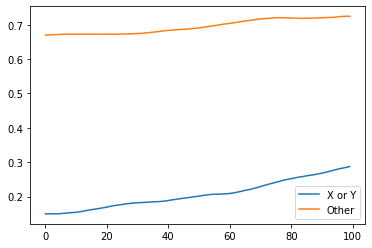

In [332]:
plt.plot(np.arange(Niterations),rab[1,:,0,0],label="X or Y")
plt.plot(np.arange(Niterations),rab[1,:,0,1],label="Other")
plt.legend()

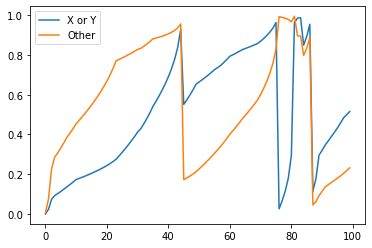

In [333]:
plt.plot(np.arange(Niterations),pred[0,:,0,0],label="X or Y")
plt.plot(np.arange(Niterations),pred[0,:,0,1],label="Other")
plt.legend()

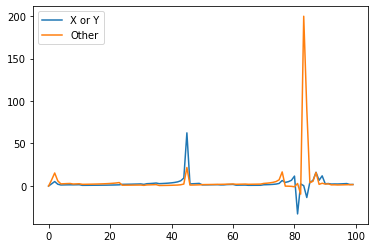

In [325]:
plt.plot(np.arange(Niterations),pred[0,:,0,2],label="X or Y")
plt.plot(np.arange(Niterations),pred[0,:,0,3],label="Other")
plt.legend()

In [294]:
pred_r = np.sqrt(pred[:,:,:,0]**2 + pred[:,:,:,1]**2)
pred_V = np.diff(pred_r,axis=1)/dt
pred_V[pred_V<0]

array([-1.91602488e+01, -3.60119033e+01, -5.44516128e+00, -1.63694301e+01,
       -2.52498307e+01, -1.42569188e+01, -3.02485305e+01, -3.87739125e+01,
       -2.39824458e+01, -4.79724418e+01, -9.02127171e+00, -4.26406222e+01,
       -8.58614354e+01, -2.39203779e+01, -3.27114389e+01, -4.32559366e+00,
       -4.93138866e+00, -7.66580899e+00, -5.84682103e+00, -7.17805261e+01,
       -2.23990207e+01, -1.23927285e+01, -4.48754178e+01, -2.23184949e+01,
       -6.73738684e+01, -7.07037424e+01, -4.70216673e+01, -1.06792952e+02,
       -1.23130310e+02, -2.70963917e+01, -4.23862250e+01, -1.21367778e+02,
       -4.39350505e+01, -2.95291709e+01, -1.13617822e+02, -4.42406917e+01,
       -3.47561553e+01, -2.79806350e-02, -3.67824252e+01, -7.96928770e+01,
       -7.66129807e+01, -8.04121782e+01, -4.18665995e+01, -3.20919913e+01,
       -3.77113598e+01, -4.67324026e+01, -8.01712498e+01, -4.44098978e+01,
       -7.51352616e+01, -3.51723242e+01, -1.89409279e+01, -1.91562295e+01,
       -1.46997559e+01, -

In [295]:
rab_r = np.sqrt(rab[:,:,:,0]**2 + rab[:,:,:,1]**2)
rab_V = np.diff(rab_r,axis=1)/dt
rab_V.shape

(50, 99, 50)

In [296]:
binning = 51
bins = np.linspace(-2,2,binning+1)
data = np.zeros((Niterations, binning))
for i in range(Niterations-1):
    counts, _ = np.histogram(rab_V[:,i,:],bins=bins)
    data[i,:] = counts

<ipython-input-297-461edaf7d546>:2: RuntimeWarning: divide by zero encountered in log
  im = ax.imshow(np.log(data[:250,:]),cmap="hot", origin="Bottom", interpolation='none',extent=[bins[0],bins[-1],0,Niterations],aspect="auto")


Text(0.5, 0, 'V bins')

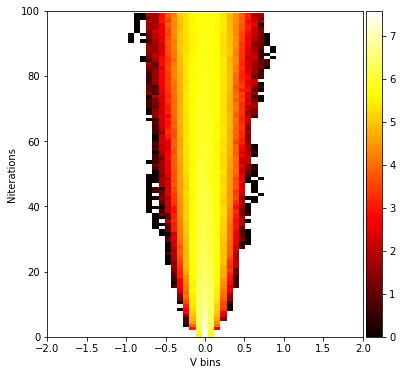

In [297]:
fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(np.log(data[:250,:]),cmap="hot", origin="Bottom", interpolation='none',extent=[bins[0],bins[-1],0,Niterations],aspect="auto")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)
ax.set_ylabel("Niterations")
ax.set_xlabel("V bins")